# Рекуррентные нейронных сетей

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [26]:
df = pd.read_csv("C:/Users/Zhastay/Downloads/jena_climate_2009_2016/data330k580k.csv")
df.head()

,Unnamed: 0,id,value,x
0,1,1,-0.01,0.71
1,2,2,0.01,0.72
2,3,3,0.02,0.71
3,4,4,-0.02,0.69
4,5,5,-0.01,0.71


In [27]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [28]:
TRAIN_SPLIT = 20000
tf.random.set_seed(13)

In [68]:
uni_data = df['value']
uni_data.index = df['id']
uni_data.head()

id
1   -0.01
2    0.01
3    0.02
4   -0.02
5   -0.01
Name: value, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC88A7E3C8>],
      dtype=object)

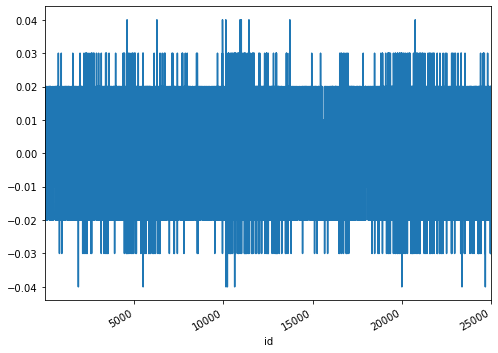

In [69]:
uni_data.plot(subplots=True)

In [70]:
uni_data = uni_data.values

In [50]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [83]:
uni_data = tf.keras.utils.normalize(uni_data)[0]

In [84]:
univariate_past_history = 360
univariate_future_target = 90

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.00595576]
 [ 0.00595576]
 [ 0.01191152]
 [-0.01191152]
 [-0.00595576]
 [ 0.00595576]
 [ 0.        ]
 [-0.00595576]
 [ 0.        ]
 [ 0.00595576]
 [-0.00595576]
 [ 0.00595576]
 [-0.00595576]
 [ 0.00595576]
 [-0.00595576]
 [ 0.00595576]
 [ 0.        ]
 [ 0.        ]
 [-0.01191152]
 [ 0.00595576]
 [ 0.        ]
 [ 0.        ]
 [ 0.00595576]
 [-0.01191152]
 [ 0.01191152]
 [-0.00595576]
 [ 0.        ]
 [ 0.        ]
 [-0.00595576]
 [ 0.00595576]
 [ 0.        ]
 [ 0.00595576]
 [ 0.        ]
 [-0.00595576]
 [ 0.00595576]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.00595576]
 [-0.01191152]
 [ 0.01191152]
 [ 0.        ]
 [-0.00595576]
 [ 0.00595576]
 [-0.00595576]
 [-0.00595576]
 [ 0.01191152]
 [-0.00595576]
 [-0.00595576]
 [ 0.00595576]
 [ 0.        ]
 [ 0.        ]
 [ 0.00595576]
 [-0.00595576]
 [ 0.00595576]
 [-0.01191152]
 [ 0.00595576]
 [ 0.        ]
 [-0.00595576]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00595576]
 [ 0.00595576]
 [ 0.     

<module 'matplotlib.pyplot' from 'c:\\users\\zhastay\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

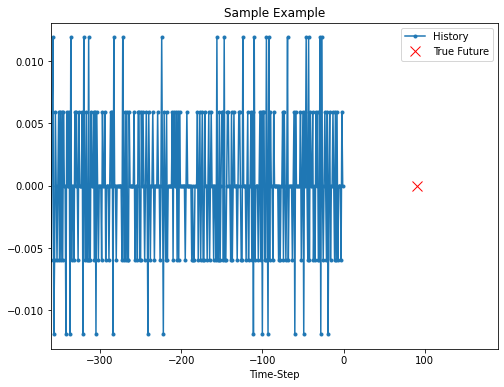

In [85]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt
show_plot([x_train_uni[0], y_train_uni[0]], 90, 'Sample Example')

<module 'matplotlib.pyplot' from 'c:\\users\\zhastay\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

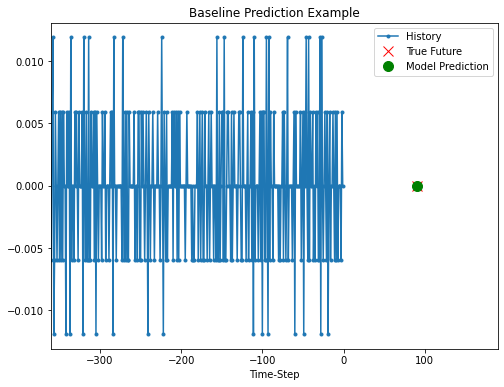

In [86]:
def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], univariate_future_target,
           'Baseline Prediction Example')

# LSTM-модель для прогнозирование

In [87]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [88]:
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [89]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [90]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [91]:
print(x_train_uni.shape)

(19640, 360, 1)


In [92]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 55s 273ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 2/10
200/200 [==============================] - 53s 263ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 3/10
200/200 [==============================] - 52s 258ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 4/10
200/200 [==============================] - 53s 264ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 5/10
200/200 [==============================] - 52s 258ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 6/10
200/200 [==============================] - 49s 247ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/10
200/200 [==============================] - 53s 265ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 8/10
200/200 [==============================] - 51s 257ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 9/10
200/200 [==============================] - 54s 272ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 10/10
200/200 [=========

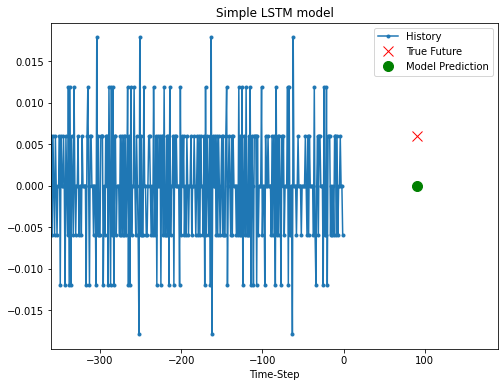

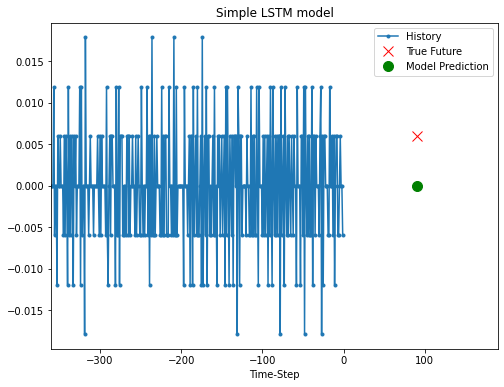

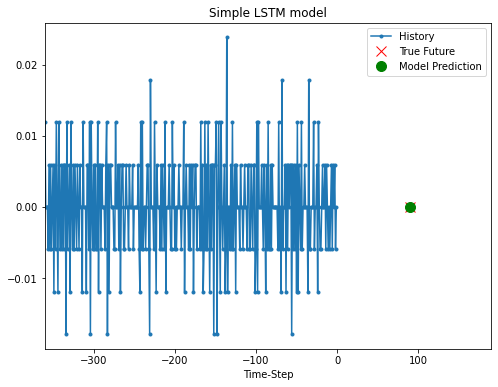

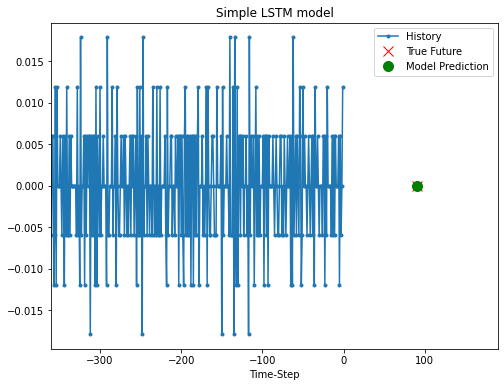

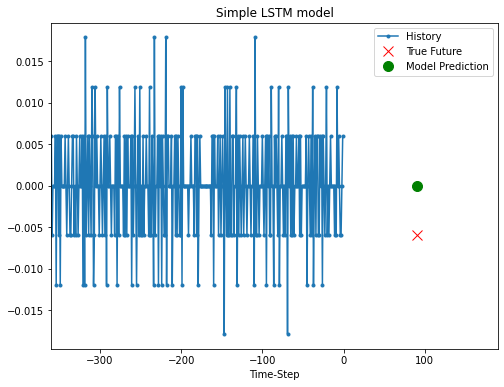

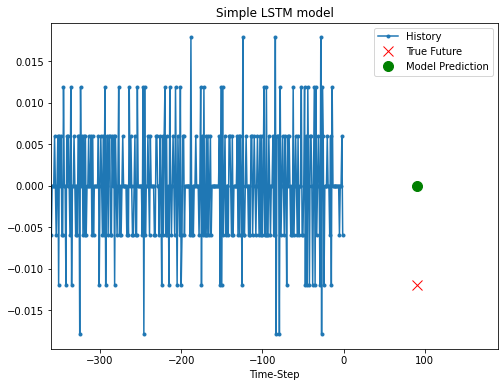

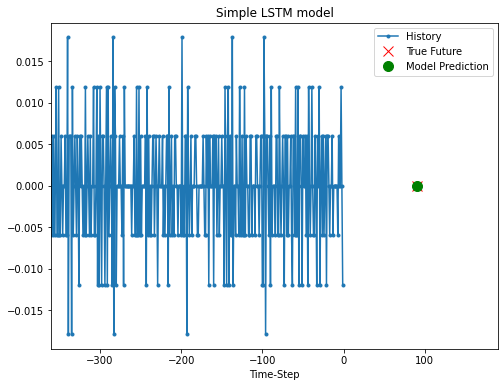

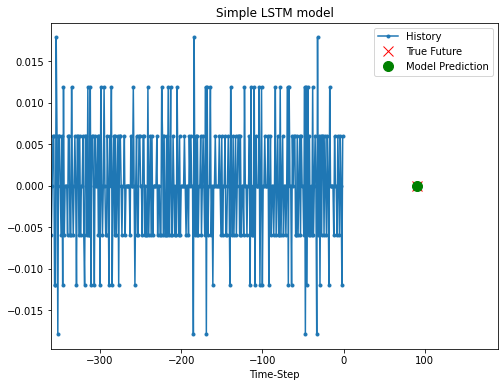

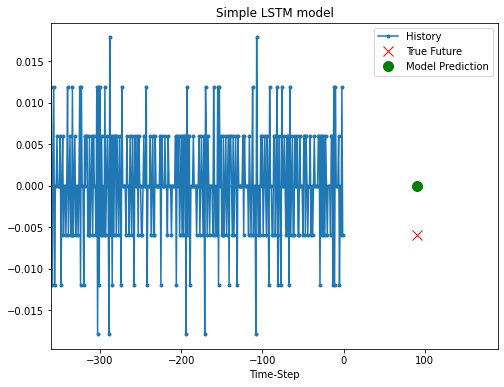

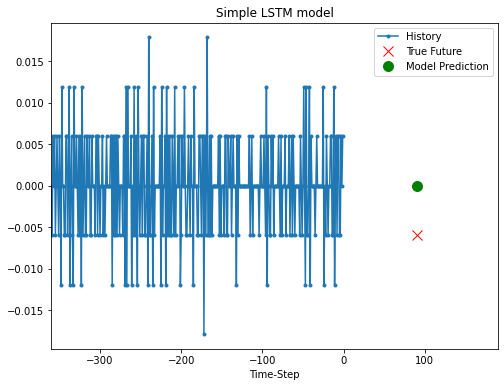

In [93]:
for x, y in val_univariate.take(10):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], univariate_future_target, 'Simple LSTM model')
  plot.show()

In [94]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

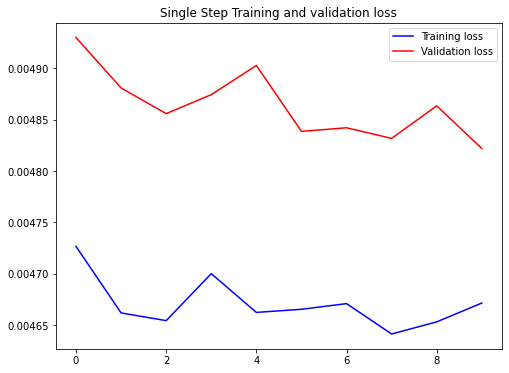

In [95]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')